In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

# Import local paths
import sys, os
sys.path.insert(0, os.path.abspath('../../..'))
sys.path.insert(0, os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs import Perception
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_grid

# pandas
import pandas as pd

# Grid

Actions:

    MOVE_LEFT = 0
    MOVE_RIGHT = 1
    MOVE_UP = 2
    MOVE_DOWN = 3


In [2]:
from lcs.metrics import population_metrics

def grid_metrics(pop, env):
#     metrics = {
#         'found_reward': env.env.s == 15,
#     }
    metrics = {
        'avg_q': sum([cl.q*cl.num for cl in pop]) / sum(cl.num for cl in pop),
#         'knowlegde': _env_knowledge(pop, env)
    }
    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [3]:
cfg = Configuration(
        classifier_length=2,
        number_of_possible_actions=4,
        epsilon=1.0,
        beta=0.1,
        gamma=0.95,
        theta_exp=50,
        theta_ga=50,
        do_ga=True,
        mu=0.4,
        u_max=2,
        metrics_trial_frequency=10)

In [4]:
 cfg = Configuration(
        classifier_length=2,
        number_of_possible_actions=4,
        epsilon=0.5 ,
        beta=0.1,
        gamma=0.9,
        theta_exp=50,
        theta_ga=50,
        theta_as=20,
        theta_i=0.1,
        theta_r=0.9,
        do_ga=True,
        mu=0.1,
        u_max=2,
        user_metrics_collector_fcn=grid_metrics,
        metrics_trial_frequency=1)
print(cfg)

ACS2Configuration:
	- Classifier length: [2]
	- Number of possible actions: [4]
	- Classifier wildcard: [#]
	- Environment adapter function: [<class 'lcs.agents.EnvironmentAdapter.EnvironmentAdapter'>]
	- Do GA: [True]
	- Do subsumption: [True]
	- Do Action Planning: [False]
	- Beta: [0.1]
	- ...
	- Epsilon: [0.5]
	- U_max: [2]


In [5]:
    cfg = Configuration(
        classifier_length=2,
        number_of_possible_actions=4,
        # epsilon=0.7, # 1.0
        epsilon=0.95,
        beta=0.1,
        gamma=0.8,
        theta_exp=20,
        theta_ga=100,
        theta_as=20,
        theta_r=0.95,
        theta_i=0.2,
        do_ga=True,
        # do_ga=False,
        mu=0.02,
        u_max=2,
        user_metrics_collector_fcn=grid_metrics,
        metrics_trial_frequency=1)

In [6]:
def print_cl(cl):
    action = None
    if cl.action == 0:
        action = '⬅'
    if cl.action == 1:
        action = '➡'
    if cl.action == 2:
        action = '⬆'
    if cl.action == 3:
        action = '⬇'
    print(f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f} q: {cl.q:.3f}]")

In [7]:
def print_simple_stats(population, metrics):
    pop_size = len(population)
    
    # avg step in trial
    steps = []
    for m in metrics:
        steps.append(m['steps_in_trial'])

    print(f"Population of {pop_size}, avg steps {sum(steps)/len(steps)}, all steps {sum(steps)}")     

## Grid

### Exploration

In [8]:
grid = gym.make('grid-20-v0')
# grid = gym.make('grid-40-v0')
grid.env.REWARD = 5000
grid._max_episode_steps = 5000

In [9]:
def get_all_possible_transitions(env):
    transitions = []

    for x in range(1,20):
        for y in range(1,20):
            for a in range(4):
                if a == 0:
                    transitions.append((min(20,x+1), 0, y))
                elif a == 1:
                    transitions.append((max(1, x-1), 1, y))
                elif a == 2:
                    transitions.append((x, 2, min(20, y+1)))
                elif a == 3:
                    transitions.append((x, 2, max(1, y-1)))

    return transitions


In [10]:
def _env_knowledge(population, environment) -> float:
    transitions = get_all_possible_transitions(environment)

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0
    return 0 # TODO

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.perception(*start)
        p1 = environment.env.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

In [11]:
%%time
agent = ACS2(cfg)
population, metrics = agent.explore(grid, 2500)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 45, 'reward': 5000, 'avg_q': 0.5368102, 'population': 25, 'numerosity': 25, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 2211, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 1407, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 115, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 242, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 417, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 1831

CPU times: user 28min 52s, sys: 1.72 s, total: 28min 54s
Wall time: 28min 59s


In [12]:
print_simple_stats(population, metrics)

Population of 80, avg steps 1501.5784, all steps 3753946


In [13]:
def population_dataframe(population, sortby='fitness*num'):
    import pandas as pd
    df = pd.DataFrame(cl.as_dict() for cl in population)
    df.insert(6, 'fitness', df['q']*df['r'])
    df.insert(7, 'fitness*num', df['fitness']*df['num'])
    df.insert(1, 'cond_x', pd.to_numeric([None if c[0] == '#' else c[0] for c in df['condition']]),True)
    df.insert(2, 'cond_y', pd.to_numeric([None if c[1] == '#' else c[1] for c in df['condition']]),True)
    df.insert(5, 'eff_x', pd.to_numeric([None if c[0] == '#' else c[0] for c in df['effect']]),True)
    df.insert(6, 'eff_y', pd.to_numeric([None if c[1] == '#' else c[1] for c in df['effect']]),True)
    return df.sort_values(sortby, ascending=False)

In [14]:
df=population_dataframe(agent.population)
df.head(20)

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
13,"[19, #]",19.0,NaN,1,"[20, #]",20.0,NaN,"[{}, {}]",1.0,626.149047,626.149047,11896.831899,501.400342,19,49773,3753945,3753922,99.694498,False,ACS2Configuration:\n\t- Classifier length: [2]...
18,"[#, 16]",NaN,16.0,2,"[#, 17]",NaN,17.0,"[{}, {}]",1.0,147.683152,147.683152,2805.979884,0.000000,19,42569,3753899,3753883,78.770363,False,ACS2Configuration:\n\t- Classifier length: [2]...
19,"[#, 17]",NaN,17.0,2,"[#, 18]",NaN,18.0,"[{}, {}]",1.0,147.514782,147.514782,2802.780860,0.000000,19,44768,3753912,3753899,69.568578,False,ACS2Configuration:\n\t- Classifier length: [2]...
16,"[20, #]",20.0,NaN,1,"[#, #]",NaN,NaN,"[{}, {}]",1.0,146.359685,146.359685,2780.834016,0.000000,19,41599,3753442,3753438,85.126474,False,ACS2Configuration:\n\t- Classifier length: [2]...
25,"[#, 18]",NaN,18.0,3,"[#, 17]",NaN,17.0,"[{}, {}]",1.0,143.129249,143.129249,2719.455737,0.000000,19,42703,3753910,3753907,75.768740,False,ACS2Configuration:\n\t- Classifier length: [2]...
17,"[#, 15]",NaN,15.0,2,"[#, 16]",NaN,16.0,"[{}, {}]",1.0,142.627178,142.627178,2709.916373,0.000000,19,41645,3753897,3753839,84.348027,False,ACS2Configuration:\n\t- Classifier length: [2]...
62,"[#, 19]",NaN,19.0,3,"[#, 18]",NaN,18.0,"[{}, {}]",1.0,142.556247,142.556247,2708.568698,0.000000,19,45030,3753942,3753904,67.642757,False,ACS2Configuration:\n\t- Classifier length: [2]...
0,"[20, #]",20.0,NaN,0,"[19, #]",19.0,NaN,"[{}, {}]",1.0,141.776010,141.776010,2693.744186,0.000000,19,47453,3753925,3753924,108.200286,False,ACS2Configuration:\n\t- Classifier length: [2]...
8,"[#, 14]",NaN,14.0,2,"[#, 15]",NaN,15.0,"[{}, {}]",1.0,141.306154,141.306154,2684.816918,0.000000,19,42079,3753894,3753837,103.155156,False,ACS2Configuration:\n\t- Classifier length: [2]...
20,"[#, 18]",NaN,18.0,2,"[#, 19]",NaN,19.0,"[{}, {}]",1.0,141.253865,141.253865,2683.823434,0.000000,19,47207,3753943,3753900,62.007773,False,ACS2Configuration:\n\t- Classifier length: [2]...


In [15]:
# df[['r']].plot.hist(by='r',bins=20)
df[['r']].plot.hist(by='r')

In [16]:
import matplotlib.pyplot as plt
def plot_success_trials(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    success = [m['reward'] for m in metrics]

    ax.plot(trials, success)
    ax.set_title("Successful Trials")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Agent found reward")

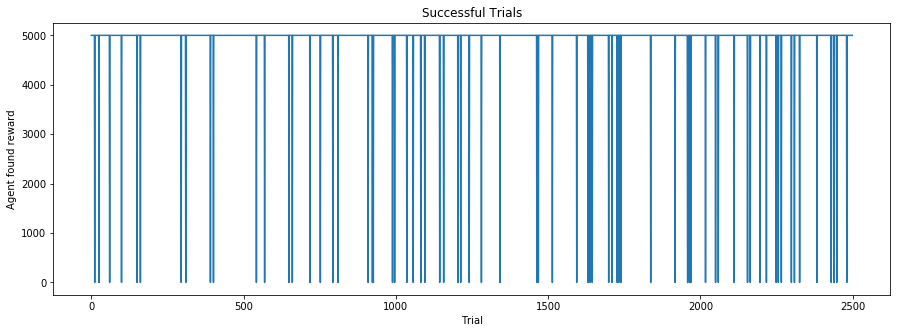

In [17]:
plt.figure(figsize=(15,5))
plot_success_trials(metrics)

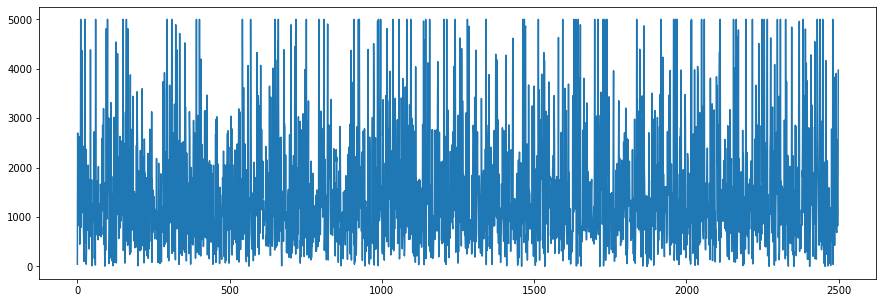

In [18]:
trials = [m['trial'] for m in metrics]
steps = [m['steps_in_trial'] for m in metrics]
plt.figure(figsize=(15,5))
plt.plot(trials, steps)

In [19]:
# df.pivot(index='cond_x', columns=['eff_x', 'action'])
gb=df.groupby('cond_x')
gb.groups

{1.0: Int64Index([71, 70], dtype='int64'),
 2.0: Int64Index([49, 69], dtype='int64'),
 3.0: Int64Index([50, 48], dtype='int64'),
 4.0: Int64Index([46, 51], dtype='int64'),
 5.0: Int64Index([45, 52], dtype='int64'),
 6.0: Int64Index([42, 53], dtype='int64'),
 7.0: Int64Index([41, 54], dtype='int64'),
 8.0: Int64Index([38, 55], dtype='int64'),
 9.0: Int64Index([37, 56], dtype='int64'),
 10.0: Int64Index([35, 57], dtype='int64'),
 11.0: Int64Index([32, 24], dtype='int64'),
 12.0: Int64Index([23, 28], dtype='int64'),
 13.0: Int64Index([29, 31], dtype='int64'),
 14.0: Int64Index([60, 30], dtype='int64'),
 15.0: Int64Index([61, 63], dtype='int64'),
 16.0: Int64Index([11, 64], dtype='int64'),
 17.0: Int64Index([12, 9], dtype='int64'),
 18.0: Int64Index([6, 3], dtype='int64'),
 19.0: Int64Index([13, 2], dtype='int64'),
 20.0: Int64Index([16, 0], dtype='int64')}

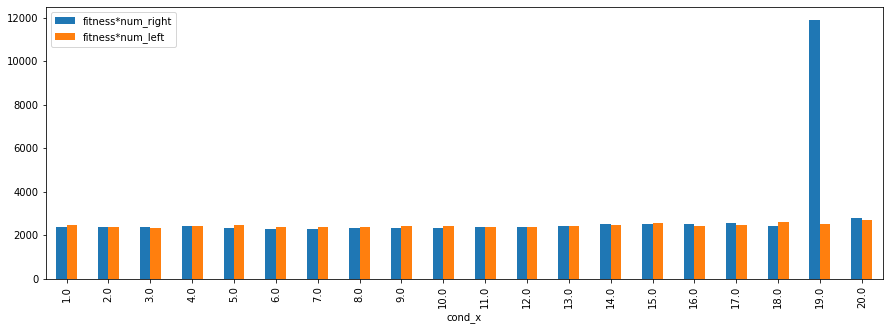

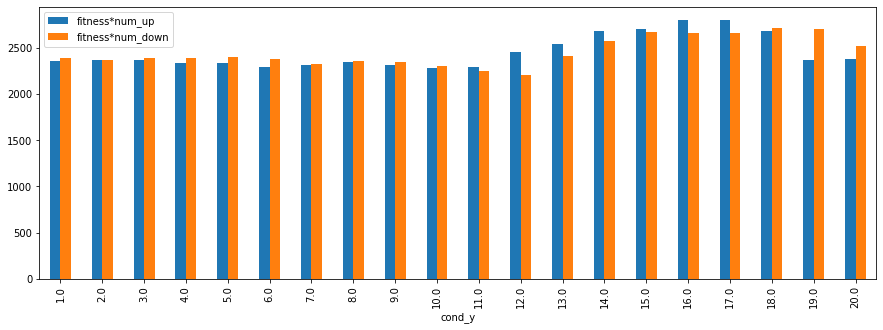

In [20]:
lr=pd.merge(df[df['action']==1][['cond_x','fitness*num']], 
         df[df['action']==0][['cond_x','fitness*num']], 
         on='cond_x', 
         suffixes=['_right','_left']).sort_values('cond_x')
ud=pd.merge(df[df['action']==2][['cond_y','fitness*num']], 
         df[df['action']==3][['cond_y','fitness*num']], 
         on='cond_y', 
         suffixes=['_up','_down']).sort_values('cond_y')
lr.plot.bar(x='cond_x',figsize=(15,5))
ud.plot.bar(x='cond_y', figsize=(15, 5))

In [21]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]    
    population_size = [m['population'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='all')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

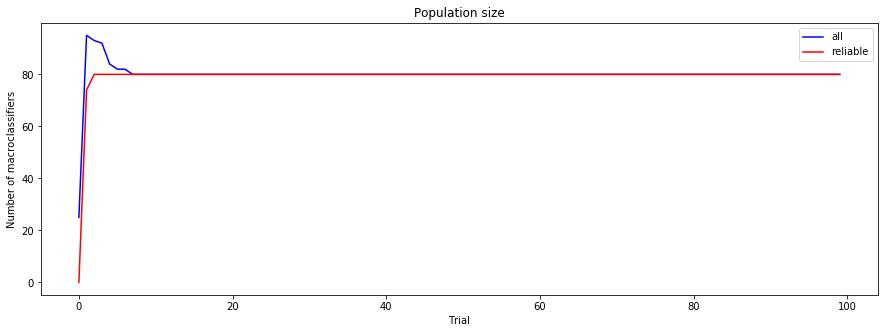

In [22]:
plt.figure(figsize=(15,5))
plot_population(metrics[:100])

In [23]:
def plot_quality(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
    trials = [m['trial'] for m in metrics]    
    avg_q = [m['avg_q'] for m in metrics]
    
    ax.plot(trials, avg_q, 'g', label='avg. quality')
    ax.set_title("Classifier stats")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Value")
    ax.legend(loc='best')

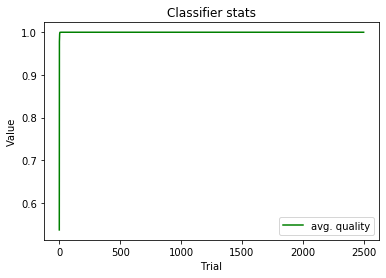

In [24]:
plot_quality(metrics)

### Exploitation

In [25]:
%%time
agent = ACS2(cfg, population)
pop_exploit, metric_exploit = agent.exploit(grid, 1000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 5000, 'reward': 0, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 5000, 'reward': 0, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 5000, 'reward': 0, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 5000, 'reward': 0, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 26, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 36, 'reward': 5000, 'avg_q': 0.9999999999999999, 'population': 80, 'numerosity': 1520, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 29,

CPU times: user 6min 46s, sys: 424 ms, total: 6min 46s
Wall time: 6min 47s


In [26]:
print_simple_stats(pop_exploit, metric_exploit)

Population of 80, avg steps 1752.512, all steps 1752512


Reward in exploit trials

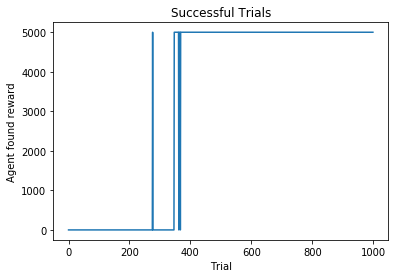

In [27]:
plot_success_trials(metric_exploit)
# metric_exploit

Steps in exploit trials

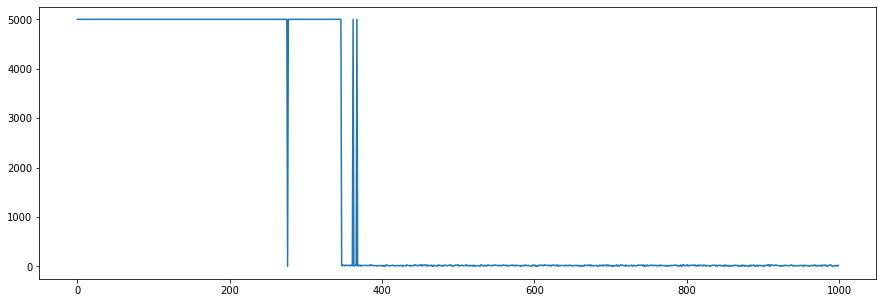

In [28]:
trials = [m['trial'] for m in metric_exploit]
steps = [m['steps_in_trial'] for m in metric_exploit]
plt.figure(figsize=(15,5))
plt.plot(trials, steps)

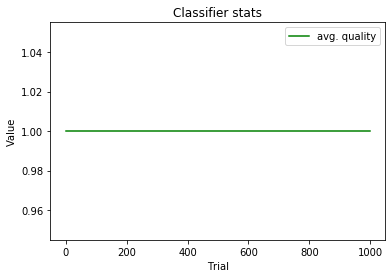

In [29]:
plot_quality(metric_exploit)

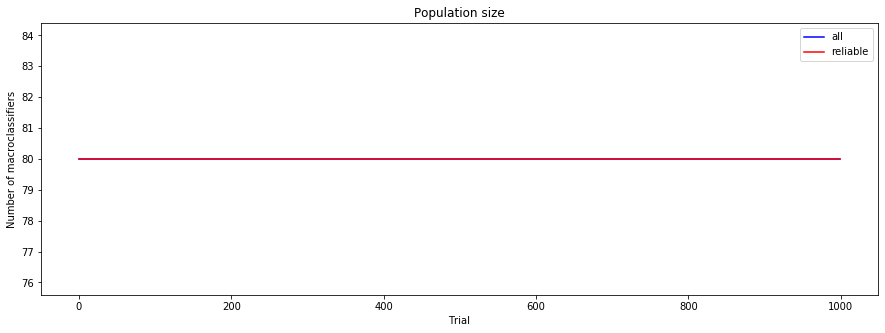

In [30]:
plt.figure(figsize=(15,5))
plot_population(metric_exploit)

In [31]:
df=population_dataframe(population)
df.head(20)

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
21,"[#, 19]",NaN,19.0,2,"[#, 20]",NaN,20.0,"[{}, {}]",1.0,5000.000000,5000.000000,95000.000000,5.000000e+03,19,49388,3753945,3753901,38.072024,False,ACS2Configuration:\n\t- Classifier length: [2]...
13,"[19, #]",19.0,NaN,1,"[20, #]",20.0,NaN,"[{}, {}]",1.0,4986.285334,4986.285334,94739.421340,4.986207e+03,19,49773,3753945,3753922,99.694498,False,ACS2Configuration:\n\t- Classifier length: [2]...
16,"[20, #]",20.0,NaN,1,"[#, #]",NaN,NaN,"[{}, {}]",1.0,146.359685,146.359685,2780.834016,0.000000e+00,19,41599,3753442,3753438,85.126474,False,ACS2Configuration:\n\t- Classifier length: [2]...
2,"[19, #]",19.0,NaN,0,"[18, #]",18.0,NaN,"[{}, {}]",1.0,132.337676,132.337676,2514.415843,0.000000e+00,19,45872,3753938,3753928,73.130687,False,ACS2Configuration:\n\t- Classifier length: [2]...
71,"[1, #]",1.0,NaN,0,"[#, #]",NaN,NaN,"[{}, {}]",1.0,128.998672,128.998672,2450.974760,0.000000e+00,19,50546,3753768,3753757,92.448291,False,ACS2Configuration:\n\t- Classifier length: [2]...
3,"[18, #]",18.0,NaN,1,"[19, #]",19.0,NaN,"[{}, {}]",1.0,127.687322,127.687322,2426.059112,0.000000e+00,19,48052,3753944,3753920,66.951603,False,ACS2Configuration:\n\t- Classifier length: [2]...
79,"[#, 1]",NaN,1.0,3,"[#, #]",NaN,NaN,"[{}, {}]",1.0,125.920119,125.920119,2392.482264,0.000000e+00,19,50610,3753474,3753472,45.777072,False,ACS2Configuration:\n\t- Classifier length: [2]...
70,"[1, #]",1.0,NaN,1,"[2, #]",2.0,NaN,"[{}, {}]",1.0,125.801053,125.801053,2390.220004,0.000000e+00,19,52469,3753790,3753759,77.813737,False,ACS2Configuration:\n\t- Classifier length: [2]...
78,"[#, 20]",NaN,20.0,2,"[#, #]",NaN,NaN,"[{}, {}]",1.0,125.195261,125.195261,2378.709962,0.000000e+00,19,41488,3753940,3753902,41.885209,False,ACS2Configuration:\n\t- Classifier length: [2]...
24,"[11, #]",11.0,NaN,1,"[12, #]",12.0,NaN,"[{}, {}]",1.0,124.240160,124.240160,2360.563049,1.976263e-323,19,45603,3753842,3753820,105.717848,False,ACS2Configuration:\n\t- Classifier length: [2]...


In [32]:
df[df['num']!=19]

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg


In [33]:
df.drop(['cond_x','cond_y','eff_x','eff_y','q','mark'], axis='columns').sort_values('ir',ascending=False)

,condition,action,effect,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
21,"[#, 19]",2,"[#, 20]",5000.000000,5000.000000,95000.000000,5.000000e+03,19,49388,3753945,3753901,38.072024,False,ACS2Configuration:\n\t- Classifier length: [2]...
13,"[19, #]",1,"[20, #]",4986.285334,4986.285334,94739.421340,4.986207e+03,19,49773,3753945,3753922,99.694498,False,ACS2Configuration:\n\t- Classifier length: [2]...
50,"[3, #]",1,"[4, #]",101.199464,101.199464,1922.789821,1.976263e-323,19,51332,3753793,3753731,71.621941,False,ACS2Configuration:\n\t- Classifier length: [2]...
49,"[2, #]",1,"[3, #]",112.835652,112.835652,2143.877387,1.976263e-323,19,51913,3753791,3753761,82.476078,False,ACS2Configuration:\n\t- Classifier length: [2]...
24,"[11, #]",1,"[12, #]",124.240160,124.240160,2360.563049,1.976263e-323,19,45603,3753842,3753820,105.717848,False,ACS2Configuration:\n\t- Classifier length: [2]...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,"[15, #]",1,"[16, #]",106.182203,106.182203,2017.461863,0.000000e+00,19,41607,3753907,3753853,63.135775,False,ACS2Configuration:\n\t- Classifier length: [2]...
60,"[14, #]",1,"[15, #]",107.273151,107.273151,2038.189870,0.000000e+00,19,42016,3753890,3753852,81.473565,False,ACS2Configuration:\n\t- Classifier length: [2]...
55,"[8, #]",1,"[9, #]",109.588583,109.588583,2082.183079,0.000000e+00,19,48974,3753815,3753811,80.247098,False,ACS2Configuration:\n\t- Classifier length: [2]...
66,"[#, 5]",2,"[#, 6]",110.618385,110.618385,2101.749321,0.000000e+00,19,51208,3753798,3753786,89.787611,False,ACS2Configuration:\n\t- Classifier length: [2]...


Let's verify if classifiers are really reliabile

In [34]:
df[(df['action']==0)!=(df['cond_x']-1==df['eff_x'])]

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
71,"[1, #]",1.0,NaN,0,"[#, #]",NaN,NaN,"[{}, {}]",1.0,128.998672,128.998672,2450.97476,0.0,19,50546,3753768,3753757,92.448291,False,ACS2Configuration:\n\t- Classifier length: [2]...


In [35]:
df[(df['action']==1)!=(df['cond_x']+1==df['eff_x'])]

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
16,"[20, #]",20.0,NaN,1,"[#, #]",NaN,NaN,"[{}, {}]",1.0,146.359685,146.359685,2780.834016,0.0,19,41599,3753442,3753438,85.126474,False,ACS2Configuration:\n\t- Classifier length: [2]...


In [36]:
df[(df['action']==2)!=(df['cond_y']+1==df['eff_y'])]

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
78,"[#, 20]",NaN,20.0,2,"[#, #]",NaN,NaN,"[{}, {}]",1.0,125.195261,125.195261,2378.709962,0.0,19,41488,3753940,3753902,41.885209,False,ACS2Configuration:\n\t- Classifier length: [2]...


In [37]:
df[(df['action']==3)!=(df['cond_y']-1==df['eff_y'])]

,condition,cond_x,cond_y,action,effect,eff_x,eff_y,mark,q,r,fitness,fitness*num,ir,num,exp,talp,tga,tav,ee,cfg
79,"[#, 1]",NaN,1.0,3,"[#, #]",NaN,NaN,"[{}, {}]",1.0,125.920119,125.920119,2392.482264,0.0,19,50610,3753474,3753472,45.777072,False,ACS2Configuration:\n\t- Classifier length: [2]...


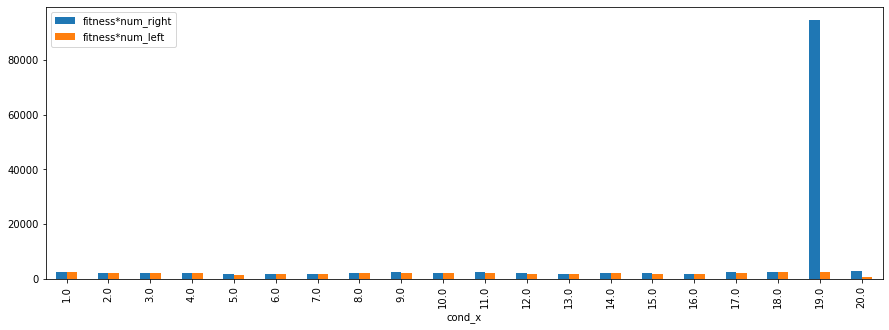

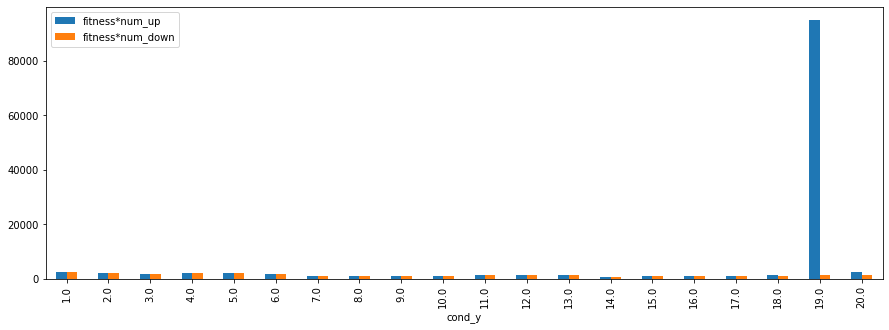

In [38]:
lr=pd.merge(df[df['action']==1][['cond_x','fitness*num']], 
         df[df['action']==0][['cond_x','fitness*num']], 
         on='cond_x', 
         suffixes=['_right','_left']).sort_values('cond_x')
ud=pd.merge(df[df['action']==2][['cond_y','fitness*num']], 
         df[df['action']==3][['cond_y','fitness*num']], 
         on='cond_y', 
         suffixes=['_up','_down']).sort_values('cond_y')
lr.plot.bar(x='cond_x',figsize=(15,5))
ud.plot.bar(x='cond_y', figsize=(15, 5))

### Manual tests

In [39]:
state = Perception(("3","4"))

match = population.form_match_set(state)
for cl in sorted(match, key=lambda cl: -cl.fitness):
    print_cl(cl) 

#4 - ⬆ - #5 [fit: 110.983, r: 110.98, ir: 0.00 q: 1.000]
#4 - ⬇ - #3 [fit: 102.069, r: 102.07, ir: 0.00 q: 1.000]
3# - ➡ - 4# [fit: 101.199, r: 101.20, ir: 0.00 q: 1.000]
3# - ⬅ - 2# [fit: 100.066, r: 100.07, ir: 0.00 q: 1.000]
